# Preprocessing

There are many preprocessors in scikit-lego and in this document we
would like to highlight a few such that you might be inspired to use
pipelines a little bit more flexibly.

## Estimators as Transformers


Sometimes you'd like the output of a model to be available as a feature
that you might use as input for another model. The issue here is that
scikit learn pipelines usually only allow a single model at the end of
a pipeline. One solution to this problem is to turn the model into a transformer.
To convert a model to become a transformer you can use the `EstimatorTransformer`
from the `meta` module.

#### Example 1

Let's demonstrate one example. Below we describe how to create a pipeline
with two models that each see the same dataset. Note that the output of this
pipeline is still only a transformer pipeline.

![](_static/estimator-transformer-1.png)

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression, Ridge

from sklego.meta import EstimatorTransformer
from sklego.preprocessing import ColumnSelector

np.random.seed(42)
n = 1000
X = np.random.uniform(0, 1, (n, 2))
y = X.sum(axis=1) + np.random.uniform(0, 1, (n,))
df = pd.DataFrame({"x1": X[:, 0], "x2": X[:, 1], "y": y})

pipeline = Pipeline([
    ("grab_columns", ColumnSelector(["x1", "x2"])),
    ("ml_features", FeatureUnion([
        ("model_1",  EstimatorTransformer(LinearRegression())),
        ("model_2",  EstimatorTransformer(Ridge()))
    ]))
])

pipeline.fit(df, y).transform(df)

array([[1.84239085, 1.8381264 ],
       [1.84487058, 1.84095898],
       [0.78867225, 0.79690879],
       ...,
       [1.92562838, 1.92076151],
       [1.52504886, 1.52524312],
       [0.81791076, 0.82568794]])

#### Example 2

Here's another example that works a little bit differently. Here
we have two models that each see different data.

![](_static/estimator-transformer-2.png)

In [2]:
pipeline = Pipeline([
    ("grab_columns", ColumnSelector(["x1", "x2"])),
    ("ml_features", FeatureUnion([
        ("p1", Pipeline([
            ("grab1", ColumnSelector(["x1"])),
            ("mod1", EstimatorTransformer(LinearRegression()))
        ])),
        ("p2", Pipeline([
            ("grab2", ColumnSelector(["x2"])),
            ("mod2", EstimatorTransformer(LinearRegression()))
        ]))
    ]))
])

pipeline.fit(df, y).transform(df)


array([[1.3810049 , 1.96265338],
       [1.75182446, 1.5942067 ],
       [1.15431258, 1.13093337],
       ...,
       [1.7719303 , 1.65521752],
       [1.98484405, 1.03984466],
       [1.05164825, 1.26300114]])

## Column Capping

Some models are great at interpolation but less good at extrapolation.
One way to potentially circumvent this problem is by capping extreme
valeus that occur in the dataset **X**.

![](_static/column-capper.png)

To see how they work we demonstrate a few examples below.

In [3]:
import numpy as np
import pandas as pd
from sklego.preprocessing import ColumnCapper

np.random.seed(42)
X = np.random.uniform(0, 1, (100000, 2))

cc = ColumnCapper()
output = cc.fit(X).transform(X)
output.min(axis=0) # array([0.05120598, 0.0502972 ])
output.max(axis=0) # array([0.95030677, 0.95088171])

cc = ColumnCapper(quantile_range=(10, 90))
output = cc.fit(X).transform(X)
output.min(axis=0) # array([0.10029693, 0.09934085])
output.max(axis=0) # array([0.90020412, 0.89859006])

array([0.90020412, 0.89859006])

```

Note that the column capper does not deal with missing values
but it does support pandas dataframes as well as infinite values.

```python
arr = np.array([[0.0, np.inf], [-np.inf, 1.0]])
cc.transform(arr) # array([[0.10029693, 0.89859006], [0.10029693, 0.89859006]])
```

## Patsy Formulas

If you're used to the statistical programming language R you might have
seen a formula object before. This is an object that represents a shorthand
way to design variables used in a statistical model. The python project [patsy](https://patsy.readthedocs.io/en/latest/)
took this idea and made it available for python. From sklego we've made a
wrapper such that you can also use these in your pipelines.

```python
import pandas as pd
from sklego.preprocessing import PatsyTransformer

df = pd.DataFrame({"a": [1, 2, 3, 4, 5],
                   "b": ["yes", "yes", "no", "maybe", "yes"],
                   "y": [2, 2, 4, 4, 6]})
X, y = df[["a", "b"]], df[["y"]].values
pt = PatsyTransformer("a + np.log(a) + b")
pt.fit(X, y).transform(X)
```
This will result in the following array:

```python
    array([[1.        , 0.        , 1.        , 1.        , 0.        ],
           [1.        , 0.        , 1.        , 2.        , 0.69314718],
           [1.        , 1.        , 0.        , 3.        , 1.09861229],
           [1.        , 0.        , 0.        , 4.        , 1.38629436],
           [1.        , 0.        , 1.        , 5.        , 1.60943791]])

```

You might notice that the first column contains the constant array
equal to one. You might also expect 3 dummy variable columns instead of 2.
This is because the design matrix from patsy attempts to keep the
columns in the matrix linearly independant of eachother.

If this is not something you'd want to create you can choose to omit
it by indicating "-1" in the formula.

```python
pt = PatsyTransformer("a + np.log(a) + b - 1")
pt.fit(X, y).transform(X)
```

This will result in the following array:

```python
    array([[0.        , 0.        , 1.        , 1.        , 0.        ],
           [0.        , 0.        , 1.        , 2.        , 0.69314718],
           [0.        , 1.        , 0.        , 3.        , 1.09861229],
           [1.        , 0.        , 0.        , 4.        , 1.38629436],
           [0.        , 0.        , 1.        , 5.        , 1.60943791]])
```

You'll notice that now the constant array is gone and it is replaced with
a dummy array. Again this is now possible because patsy wants to guarantee
that each column in this matrix is linearly independant of eachother.

The formula syntax is pretty powerful, if you'd like to learn we refer you
to [formulas](https://patsy.readthedocs.io/en/latest/formulas.html) documentation.




## Repeating Basis Function Transformer

Some variables are of a circular nature. For example, the days of the year, 1-Jan-2019 (day 1) is just as close to 2-Jan-2019 (day 2) as it is to 31-Dec-2018 (day 365). If you would encode day of year numerically you would lose this information, as 1 close 2 to but far from 365. The repeating basis function transformer can remedy this problem.

The transformer selects a column and transforms it with a given number of repeating (radial) basis functions, which have a bell curve shape. The basis functions are equally spaced over the input range. The key feature of repeating basis funtions is that they are continuous when moving
from the max to the min of the input range. As a result these repeating basis functions can capture how close each datapoint is to the center of each repeating basis function, even when the input data has a circular nature. 

#### Example

Let's make some random data to start with. We have input data `day`, `day_of_year` and target `y`.

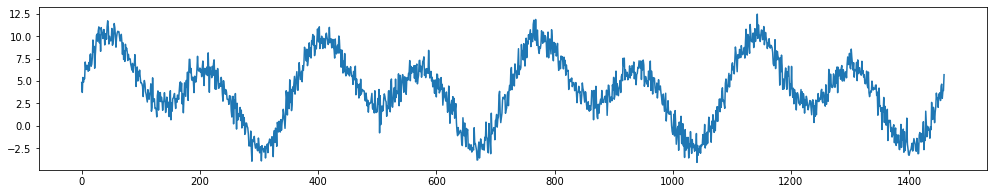

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# generate features
X = pd.DataFrame()
X['day'] = np.arange(4*365)
X['day_of_year'] = 1 + X['day'] % 365

# generate target
signal1 = 4 + 3*np.sin(X['day']/365*2*np.pi) 
signal2 = 4 * np.sin(X['day']/365*4*np.pi+365/2)
noise = np.random.normal(0, 0.9, len(X['day']))       
y = signal1 + signal2 + noise

# plot
fig = plt.figure(figsize=(17,3))
ax = fig.add_subplot(111)
ax.plot(X['day'],y);

Let's create repeating basis functions based on `day_of_year`

In [5]:
from sklego.preprocessing import RepeatingBasisFunction

N_PERIODS = 4
rbf = RepeatingBasisFunction(n_periods=N_PERIODS,
                             remainder='passthrough',
                             column='day_of_year',
                             input_range=(1,365))
rbf.fit(X)
Xt = rbf.transform(X)

Now let's plot our transformed features

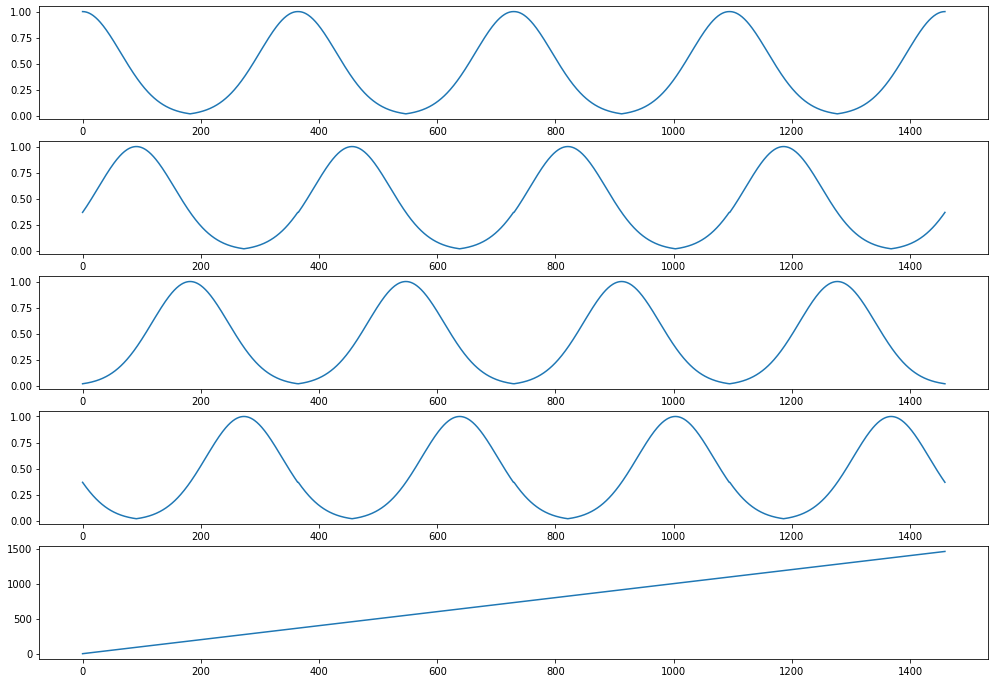

In [6]:
fig, axes = plt.subplots(nrows=Xt.shape[1], figsize=(17,12))
for i in range(Xt.shape[1]):
    axes[i].plot(X['day'], Xt[:,i]) 
plt.show()

The `day_of_year` feature has been replaced with `N_PERIODS` repeating basis functions. These are bell curves that are equidistant over the 1-365 range. Each curve captures the information of "being close to" a particular `day_of_year`. For example, the curve in the top row captures how close a day is to new year's day. It peaks on day 1 with a value of 1 and smoothly drops at an equal rate in December and in the rest of January. 

Note, how the `day` feature still exists, in the transformed feature set as a result of the `remainder='passthrough'` setting. The default setting `remainder='drop'` will only keep the repeating basis functions and drop all columns of the original dataset.